# Gradient Boosting Decision Tree (GBDT)

このハンズオンでは、勾配ブースティング手法のライブラリであるLightGBMを使って、構造化(テーブル)データに対してのモデルを作成していきます。

また勾配ブースティングでは、比較的簡単に予測結果の判断根拠も求めることができます。

この利点としては
- 予測の判断根拠自体が推論システムとしてあると何かと便利
- 学習したモデルが一般的な常識/知見に基づいた特徴量であるか確認できる  

などが挙げられます。

このような、予測結果の判断根拠を得る手法についても紹介していきます。

In [ ]:
# 必要なライブラリ類のインストール
# 2回目以降は実行不要
!pip install lightgbm shap category_encoders storage

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from io import BytesIO
from google.cloud import storage

In [2]:
## GoogleCloudStorageの接続
project_id = 'hr-mixi'
buclet_name = 'mixi-ml-handson-2023'

client = storage.Client(project_id)
bucket = client.get_bucket(buclet_name)

## データセットの読み込み
今回は、実データを用いたタスクに挑戦していきます。  
具体的には、過去数年の競輪のレースデータを使って、着順予測をしていきます。

<font color='red'>**注意: 今回のデータは非公開データとなります。本研修外での利用はお控えください。**</font>

GCSにデータを置いているので、取得します。

In [3]:
training_data_path = '05_predict_structured_data/training_data/race_data.csv'

blob = bucket.blob(training_data_path)
content = blob.download_as_string()
df = pd.read_csv(BytesIO(content))

取得できたら、データを観察してみましょう。 

In [4]:
# データサイズの確認
df.shape

(575564, 150)

In [5]:
# データの機関の確認
'日付開始日: {}, 日付終了日: {}'.format(df['KaisaiDate'].max(), df['KaisaiDate'].min())

'日付開始日: 20230430, 日付終了日: 20200101'

In [6]:
# データの統計量の確認
df.describe()

,RaceId,KaisaiDate,JyoCD,RaceNum,SenshuCD,Wakuban,Syaban,Kaiji,Setsu,Nichiji,...,SensyuNowKyoriPlaceCount,SensyuRaceJyuniAvg,SensyuNowJyoCDRaceJyuniAvg,SensyuNowSyabanRaceJyuniAvg,SensyuNowGradeRaceJyuniAvg,SensyuNowKyoriRaceJyuniAvg,KimariMakuriCount,SensyuMarkCount,SensyuNigeCount,SensyuSashiCount
count,5.755640e+05,5.755640e+05,575564.000000,575564.000000,575564.000000,575564.000000,575564.000000,563815.000000,575564.000000,575564.000000,...,575564.000000,575250.000000,562490.000000,573448.000000,574394.000000,563957.000000,575564.00000,575564.000000,575564.000000,575564.000000
mean,2.021334e+11,2.021334e+07,48.527835,5.932704,14074.135064,3.835897,4.104301,7.451003,0.925447,2.048990,...,30.013079,5.609597,5.569062,5.568059,5.578297,5.167251,45.25827,0.009439,35.385802,59.428771
std,9.693617e+07,9.693615e+03,22.491354,3.231446,1047.565330,1.772299,2.121107,4.354990,0.828220,0.884386,...,28.986555,1.269815,3.693635,2.205470,1.646387,2.981746,48.49713,0.101450,47.481970,44.274629
min,2.020010e+11,2.020010e+07,11.000000,1.000000,10014.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.818200,-1.000000,-1.000000,-1.000000,-1.000000,0.00000,0.000000,0.000000,0.000000
25%,2.020120e+11,2.020120e+07,28.000000,3.000000,13397.000000,2.000000,2.000000,4.000000,0.000000,1.000000,...,6.000000,5.040100,4.000000,4.272700,4.801400,3.918900,5.00000,0.000000,0.000000,20.000000
50%,2.021101e+11,2.021101e+07,46.000000,6.000000,14221.000000,4.000000,4.000000,7.000000,1.000000,2.000000,...,21.000000,5.622900,4.692300,5.398100,5.498900,4.720000,28.00000,0.000000,11.000000,57.000000
75%,2.022073e+11,2.022073e+07,71.000000,9.000000,14934.000000,6.000000,6.000000,11.000000,2.000000,3.000000,...,47.000000,6.239275,6.000000,6.576100,6.280700,5.777800,75.00000,0.000000,59.000000,89.000000
max,2.023043e+11,2.023043e+07,86.000000,12.000000,15773.000000,8.000000,9.000000,72.000000,2.000000,6.000000,...,227.000000,99.000000,99.000000,99.000000,99.000000,99.000000,390.00000,2.000000,435.000000,323.000000


In [7]:
# 0行目のデータの内容
for c in df.columns:
    print(c, df.iloc[0][c])

RaceId 202001015306
KaisaiDate 20200101
JyoCD 53
RaceNum 6
SenshuCD 13979
Wakuban 5
Syaban 6
Kaiji 8.0
Setsu 2
Nichiji 2
Ki 0
Age 39
Kyu Ａ
Han ２
Fuken 北海
Gear 3.86
Graduate 89
RaceRating 82.75
Shokin 9153200
Lank 1027
Kyakushitu 両
Kimari nan
IJyoCD nan
KakuteiJyuni 9.0
AgariTime 12.2
ChakusaCD 大差
StdGet 0.0
JanGet 0.0
HomeGet 0.0
BackGet 0.0
KaisaiGrade F1
Hondai 準決勝
GaiteiName Ａ級
Kyori 2015.0
HassoTime 13:32
SyaNum 9.0
RaceIdOld1 201912315303.0
KaisaiDateOld1 20191231.0
JyoCDOld1 53.0
RaceNumOld1 3.0
WakubanOld1 1.0
SyabanOld1 1.0
KaijiOld1 8.0
SetsuOld1 2.0
NichijiOld1 1.0
GearOld1 3.86
RaceRatingOld1 82.75
KimariOld1 nan
IjyoCDOld1 nan
KakuteiJyuniOld1 3.0
AgariTimeOld1 10.5
ChakusaCDOld1 3/4身
StdGetOld1 0.0
JanGetOld1 0.0
HomeGetOld1 0.0
BackGetOld1 0.0
HondaiOld1 予　選
GaiteiNameOld1 Ａ級
KyoriOld1 2015.0
HassoTimeOld1 12:00
SyaNumOld1 9.0
RaceIdOld2 201912315303.0
KaisaiDateOld2 20191231.0
JyoCDOld2 53.0
RaceNumOld2 3.0
WakubanOld2 1.0
SyabanOld2 1.0
KaijiOld2 8.0
SetsuOld2 2.0
Nichi

**NOTE:** 今回は時間の都合上各カラムのデータをさらっと眺めるだけにしていますが、機械学習モデルを開発する上で、データへの理解度(ドメイン知識)は非常に重要な要素となってきます。  
データのAnalysisだけでも時間をかける価値があるということを理解しておいてください。

## ターゲットデータの作成
次に、データからラベルを作成していきます。  
今回は、KakuteiJyuniつまり着順を使用します。

このとき、着順をそのままラベルに使用する場合、着順それぞれを1クラスとした多クラス分類となります。  
多クラス分類になると、それぞれのクラスを独立したものとして扱うことになりますが、1着と2着などを別クラスとして扱うことは正しいでしょうか。  

例えば工夫した考え方として、ラベルを`3着以内orNot`や`1着orNot`に変換する方法も考えられます。  
このようにした場合、今回のタスクは２値分類タスクとなります。  
また、`1着orNot`にした場合、出力は確率になるので、その確率が高い順と考えると、結果的に着順も予測できることになります。  

ラベルをどのように扱えばより良いかは自分で考える必要があるので、このようなドメイン知識が重要になってきます。  

初回はそのまま着順をそのままラベルに使用した多クラス分類モデルを作成します

<Challenge>
後ほど、各々ここのターゲットを各自変えて再度モデルを学習し直してもらいます   
    
- ヒント: メモリ上に実行した引数が残ってしまっていると意図した動作をしないケースが発生するので、モデルを作り直す場合はカーネルリセットをお勧めします
    
サンプル
・1着orNotの2値分類
```
target = df['KakuteiJyuni'].apply(lambda x: 1 if x == 1 else 0)
```
    
・3着以内orNotの2値分類
```
target = df['KakuteiJyuni'].apply(lambda x: 1 if x <= 3 else 0)
```

In [8]:
# LightGBMのマルチクラス分類のラベルは0から始まる連番である必要があるので、
# 1着 → 0, 2着 → 1　...のように変換します
target = df['KakuteiJyuni'] - 1

## 学習/テスト用データセットの分割

テストデータは日付で2023/01/01以降のレースを対象とします。

In [9]:
train_test_split_date = 20230101

train_index = df[df['KaisaiDate'] < train_test_split_date].index
test_index = df[df['KaisaiDate'] >= train_test_split_date].index

df_train = df.loc[train_index].reset_index(drop=True)
target_train = target[train_index].values

df_test = df.loc[test_index].reset_index(drop=True)
target_test = target[test_index].values

## 前処理
前処理では一般的に以下のような処理を行います。  

- 文字列やカテゴリカルなデータを数値やベクトルに変換(LabelEncording, OneHotEncordingなど)  
- アルゴリズムが学習しやすいように変換(欠損値処理、正規化など)  
- 組み合わせや集計処理によって新しい特徴量を作成  
など

前処理コードを学習と予測用で分けているのは、予測時に学習時のラベルエンコーディングのIDのマップと同じようにIDを振り分ける必要がある等、学習時と同様のデータの変換をするように予測用の前処理コードに記載する必要があるためです。  
今回もタスクに必要な前処理を行っていきます。

**\<チャレンジ\>**  
余裕があれば、特徴量の変換や集計で新しい特徴量を作成してみてください。

In [10]:
# 学習に使用しないカラムのリスト
# ・結果データ・選手/レースを識別してしまうデータを取り除く
unuse_feature_list = [
    'RaceId', 'KaisaiDate', 'SenshuCD', 'Kimari', 'IJyoCD', 'KakuteiJyuni', 'AgariTime', 'ChakusaCD', 'StdGet', 'JanGet', 'HomeGet', 'BackGet',
    'Hondai', 'GaiteiName', 'HassoTime', 'HassoTimeOld1', 'HassoTimeOld2', 'HassoTimeOld3'
]

# レース内の集計をする特徴量
stat_columns = [
    'Age', 'Gear', 'Graduate', 'RaceRating', 'Shokin'
]

# カテゴリカル特徴量のリスト
categorical_feature_list = [
    # 今回レースに関する特徴量
    'JyoCD', 'KaisaiGrade', 'Kyori',
    # 選手に関する特徴量
    'Kyu', 'Han', 'Fuken', 'Kyakushitu',
    # 1走前レースに関する特徴量
    'JyoCDOld1', 'RaceNumOld1', 'HondaiOld1', 'GaiteiNameOld1','KyoriOld1',
    # 1走前選手に関する特徴量
    'SyabanOld1', 'ChakusaCDOld1', 'StdGetOld1', 'JanGetOld1', 'HomeGetOld1', 'BackGetOld1',
    # 2走前レースに関する特徴量
    'JyoCDOld2', 'RaceNumOld2', 'HondaiOld2', 'GaiteiNameOld2','KyoriOld2',
    # 2走前選手に関する特徴量
    'SyabanOld2', 'ChakusaCDOld2', 'StdGetOld2', 'JanGetOld2', 'HomeGetOld2', 'BackGetOld2',
    # 3走前レースに関する特徴量
    'JyoCDOld3', 'RaceNumOld3', 'HondaiOld3', 'GaiteiNameOld3','KyoriOld3',
    # 3走前選手に関する特徴量
    'SyabanOld3', 'ChakusaCDOld3', 'StdGetOld3', 'JanGetOld3', 'HomeGetOld3', 'BackGetOld3',
    # 決まり手に関する特徴量
    'KimariOld1', 'KimariOld2', 'KimariOld3'
]

import category_encoders as ce


def training_preprocessing(df):
    # カテゴリカル変数の処理
    # LightGBMでは、ラベルエンコーディング(カテゴリをintでID付け)して、typeをcategoryに変換すればライブラリが上手く扱ってくれる
    categorical_encorder = ce.OrdinalEncoder(cols=categorical_feature_list, handle_unknown='impute')
    
    df = categorical_encorder.fit_transform(df)
        
    # レース内での平均値の特徴量の作成
    race_mean = df.groupby(['RaceId'])[stat_columns].mean()

    race_mean = race_mean.rename(columns= {x: x+'Mean' for x in race_mean.columns})
    df = pd.merge(df, race_mean, how='left', on=['RaceId'])
    
    # レース内での中央値の特徴量の作成
    race_median = df.groupby(['RaceId'])[stat_columns].median()

    race_median = race_median.rename(columns= {x: x+'Median' for x in race_median.columns})
    df = pd.merge(df, race_median, how='left', on=['RaceId'])
    
    # 不要なカラムを削除する
    df = df.drop(unuse_feature_list, axis=1)

    return df, categorical_encorder


def prediction_preprocessing(df, categorical_encorder):
    # カテゴリカル変数の処理
    df = categorical_encorder.transform(df)
        
    # レース内での平均値の特徴量の作成
    race_mean = df.groupby(['RaceId'])[stat_columns].mean()

    race_mean = race_mean.rename(columns= {x: x+'Mean' for x in race_mean.columns})
    df = pd.merge(df, race_mean, how='left', on=['RaceId'])
    
    # レース内での中央値の特徴量の作成
    race_median = df.groupby(['RaceId'])[stat_columns].median()

    race_median = race_median.rename(columns= {x: x+'Median' for x in race_median.columns})
    df = pd.merge(df, race_median, how='left', on=['RaceId'])
    
    # 不要なカラムを削除する
    df = df.drop(unuse_feature_list, axis=1)

    return df


In [11]:
# 前処理の実行には1分程度かかります
preproessed_df_train, categorical_encorder = training_preprocessing(df_train)

In [12]:
preproessed_df_train

,JyoCD,RaceNum,Wakuban,Syaban,Kaiji,Setsu,Nichiji,Ki,Age,Kyu,...,AgeMean,GearMean,GraduateMean,RaceRatingMean,ShokinMean,AgeMedian,GearMedian,GraduateMedian,RaceRatingMedian,ShokinMedian
0,1,6,5,6,8.0,2,2,0,39,1,...,37.222222,3.908889,91.888889,86.778889,9.542700e+06,37.0,3.92,97.0,85.18,9153200.0
1,2,8,6,9,10.0,1,1,0,42,2,...,38.285714,3.921429,87.714286,98.031429,1.555654e+07,39.0,3.92,88.0,98.96,16210500.0
2,2,9,1,1,10.0,1,1,0,43,2,...,36.125000,3.921250,91.750000,97.501250,1.439741e+07,37.5,3.92,90.5,97.24,13475550.0
3,2,9,2,2,10.0,1,1,0,29,2,...,36.125000,3.921250,91.750000,97.501250,1.439741e+07,37.5,3.92,90.5,97.24,13475550.0
4,2,9,3,3,10.0,1,1,0,39,2,...,36.125000,3.921250,91.750000,97.501250,1.439741e+07,37.5,3.92,90.5,97.24,13475550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512098,41,9,5,5,10.0,2,1,0,27,2,...,38.142857,3.922857,94.142857,101.354286,1.741814e+07,40.0,3.92,91.0,101.29,15244000.0
512099,41,10,1,1,10.0,2,1,0,43,2,...,37.000000,3.911429,92.571429,101.225714,1.800656e+07,39.0,3.92,89.0,102.19,17003800.0
512100,41,10,2,2,10.0,2,1,0,24,2,...,37.000000,3.911429,92.571429,101.225714,1.800656e+07,39.0,3.92,89.0,102.19,17003800.0
512101,41,9,6,7,10.0,2,1,0,21,2,...,38.142857,3.922857,94.142857,101.354286,1.741814e+07,40.0,3.92,91.0,101.29,15244000.0


## 学習データから検証データを分割

学習用と検証用は8:2で分割しています。  
検証用データは、モデル学習時のtest_lossの計算のほか、  
パラメーターの自動チューニング時のloss指標の計算に使用されます。

In [13]:
val_rate = 0.2

train_val_split_point = int(len(df_train)*(1-val_rate))

preproessed_df_val = preproessed_df_train.iloc[train_val_split_point:].reset_index(drop=True)
preproessed_df_train = preproessed_df_train.iloc[:train_val_split_point].reset_index(drop=True)

target_val = target_train[train_val_split_point:]
target_train = target_train[:train_val_split_point]

## 学習

準備が整ったので、モデルの学習をさせていきます。

主要なLightGBMのパラメータを下記の通りです。

```
- 出力形式に関する要素
    - objective
        - regression: 回帰
        - binary: 二値分類
        - multiclass: 多クラス分類
    - metric
        - 回帰
            - mae: mean absolute error: 平均絶対誤差
            - mse: mean squared error: 平均2乗誤差
        - 二値分類
            - binary_logloss:　クロスエントロピー
            - binary_error: 正解率
        - 多クラス分類
            - multi_logloss: softmax
            - multi_error: 正解率
- モデル構造に関する要素
    - learning_rate: 学習率 Default=0.1 0以上
    - num_iterations: 木の数
    - num_leaves: 葉(条件の数)
    - max_depth: 木の深さの最大値
```

公式リファレンス　https://lightgbm.readthedocs.io/en/latest/Parameters.html
  
**\<チャレンジ\>** 
余裕が有れば、lgb_paramsに任意のパラメータを追加して、モデルの精度の変化を観察してください

In [14]:
# 目的変数のラベル数の確認
target.unique()

array([8., 1., 3., 5., 6., 0., 7., 4., 2.])

In [15]:
# 着順の多クラス分類モデルの学習

lgb_train = lgb.Dataset(preproessed_df_train, target_train)
lgb_test = lgb.Dataset(preproessed_df_val, target_val, reference=lgb_train)

## <TODO> lgb_paramsのobjectiveとmetricとnum_classを正しい値で埋めてください
lgb_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'num_class': 9,
    'early_stopping_rounds': 50,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
}

booster = lgb.train(
    lgb_params, lgb_train, valid_sets=lgb_test
)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14030
[LightGBM] [Info] Number of data points in the train set: 409682, number of used features: 138
[LightGBM] [Info] Start training from score -1.950517
[LightGBM] [Info] Start training from score -1.952957
[LightGBM] [Info] Start training from score -1.952717
[LightGBM] [Info] Start training from score -1.954714
[LightGBM] [Info] Start training from score -1.960731
[LightGBM] [Info] Start training from score -2.004563
[LightGBM] [Info] Start training from score -2.144576
[LightGBM] [Info] Start training from score -3.863270
[LightGBM] [Info] Start training from score -3.970661
[1]	valid_0's multi_logloss: 1.99093
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.96633
[3]	valid_0's multi_

学習が始まって、経過が確認できるでしょうか

## モデルの判断根拠: Importance

学習が完了したら、特徴量毎のImportanceを確認してみましょう。  
feature_importanceメソッドでモデルにおける特徴量の重要度を得られます。  
重要度の指標:
- split: 決定木の分岐を使用した数  
- gain: その特徴量が使用する分岐からの目的関数の減少  

In [16]:
# テストデータの前処理の実行
preprocessed_df_test = prediction_preprocessing(df_test, categorical_encorder)

In [17]:
# split
importance = pd.DataFrame(
    booster.feature_importance(importance_type = 'split'),
    index=preproessed_df_train.columns,
    columns=['importance']
)
importance.sort_values(['importance'], ascending=False)

,importance
RaceRating,1915
RaceRatingMean,1693
RaceRatingMedian,1478
RaceRatingOld1,1016
SensyuNowKyoriRaceJyuniAvg,792
...,...
KakuteiJyuniOld3,0
IjyoCDOld3,0
KimariOld3,0
RaceRatingOld3,0


In [18]:
# gain
importance = pd.DataFrame(
    booster.feature_importance(importance_type = 'gain'),
    index=preproessed_df_train.columns,
    columns=['importance']
)
importance.sort_values(['importance'], ascending=False)

,importance
SyaNum,371317.404806
RaceRating,110908.391135
RaceRatingMean,83192.811889
RaceRatingMedian,70743.514034
SensyuNowSyabanWinCount,52736.192477
...,...
JanGetOld3,0.000000
StdGetOld3,0.000000
ChakusaCDOld3,0.000000
AgariTimeOld3,0.000000


## モデルの判断根拠: SHAP
また、SHAPを用いることでも、特徴量がモデル/予測に対してどのような影響を与えたかを計測できます。  
試してみましょう。

In [19]:
import shap
shap.initjs()

In [20]:
#LightGBMは決定木アルゴリズムなのでTreeExplainerを使います
# NNモデルでDeepExplainerを使うと今回のようなテーブルデータだけでなく、画像データに対しても適用することができます
# ２分程度時間がかかります

explainer = shap.TreeExplainer(booster, feature_perturbation = "tree_path_dependent")
shap_values = explainer.shap_values(preprocessed_df_test.values)

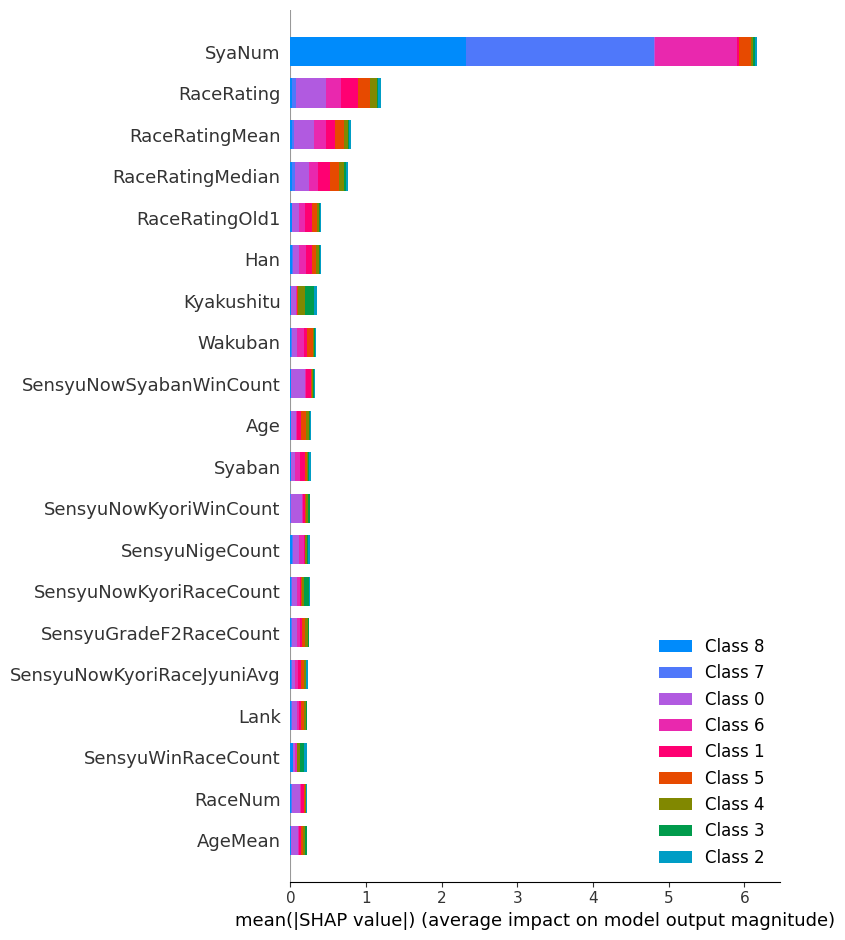

In [21]:
# 特徴量の貢献度をプロット
shap.summary_plot(shap_values, preprocessed_df_test, plot_type="bar")

### 予測ごとの判断根拠
shap_valuesには各予測に対しての各特徴量の貢献度が格納されています。  
これを使うことで、例えばあるレースの結果の予測は、この特徴量が強く影響しているためという表現ができるようになります。  

検証用データの0番目の予測結果を見てみましょう。

In [22]:
idx = 0

shap_v = pd.DataFrame(shap_values[1], columns=preprocessed_df_test.columns)

In [23]:
# 予測結果に対しでpositiveな影響を与えている特徴量
shap_v.iloc[idx].sort_values(ascending=False).iloc[:10]

RaceRating                     0.405822
RaceRatingOld1                 0.151776
Han                            0.082773
Syaban                         0.079682
Lank                           0.072564
Age                            0.057981
SensyuNowSyabanRaceJyuniAvg    0.057764
SensyuNowKyoriPlaceCount       0.053130
SensyuNigeCount                0.049710
SensyuNowKyoriWinCount         0.043961
Name: 0, dtype: float64

In [24]:
# 予測結果に対しでnegativeな影響を与えている特徴量
shap_v.iloc[idx].sort_values(ascending=True).iloc[:10]

RaceRatingMean            -0.256698
RaceRatingMedian          -0.158262
RaceNum                   -0.064871
KimariMakuriCount         -0.037940
SensyuRaceJyuniAvg        -0.037327
AgeMean                   -0.033045
SensyuWinRaceCount        -0.026440
SensyuNowKyoriRaceCount   -0.021614
Wakuban                   -0.017943
SensyuSashiCount          -0.016285
Name: 0, dtype: float64

## 精度検証

特徴量の貢献度はあらかた調べられたので、締め括りとしてこのモデルの精度の評価をしましょう。
今回の精度指標は、  
`レース内で最も1着である確率である確率が高いと評価された選手が実際に1着であった確率`  
と設定します。

データは１行で1選手を表現しているため、1レース単位は複数行を集約する必要があります。  
groupbyを使ってレースごとのindexを取得していきましょう。

In [25]:
race_groups = df_test.groupby(['RaceId']).groups

### 着順の多クラス分類モデル

In [26]:
# 予測結果の取得
prediction_result = booster.predict(preprocessed_df_test)

In [27]:
# 予測結果の0番目の出力
# 9つの要素がありそれぞれが各ラベルの確率を表現しています、つまり合計は1になります

# Challengeで目的変数を2値分類にした場合出力される予測結果の形変わります
print(prediction_result[0])

[2.85948819e-01 2.69936816e-01 1.24523663e-01 9.85745461e-02
 7.11084176e-02 6.86008632e-02 8.12891161e-02 8.68448349e-06
 9.07475207e-06]


In [28]:
# レースごとの出力値の0番目(1着と推定した確率)がもっとも大きい(np.argmax)選手の実際の着順が1着だった数/レースの数
[
    df_test.iloc[idx[np.argmax(
        [
            res[0] for res in prediction_result[idx]
        ]
    )]]['KakuteiJyuni']
    for race, idx in race_groups.items()
].count(1) / len(race_groups)

0.4594031160851437

========================================================================

# やってみよう: リアルタイムの競輪レース予測

ここまでで、GBDTのハンズオンは一通り終了です。  
ですが、折角競輪の予測を作ったので、実際に今日のレースを予測してみましょう！

GCSに本日のレースデータのcsvを作成してあります。  
このデータに対する予測結果を作成して、今日の全レースに対する予測を作成していきましょう。

In [29]:
# 本日のレースデータをGCSから取得
prediction_data_path = '05_predict_structured_data/prediction_data/race_data.csv'
blob = bucket.blob(prediction_data_path)
content = blob.download_as_string()
prediction_df = pd.read_csv(BytesIO(content))

In [30]:
# ソート
prediction_df = prediction_df.sort_values(['KaisaiDate', 'JyoCD', 'RaceNum', 'Syaban']).reset_index(drop=True)

# groupsの作成
prediction_race_groups = prediction_df.groupby(['JyoCD', 'RaceNum']).groups

# 前処理の実行
preprocessed_prediction_df = prediction_preprocessing(prediction_df, categorical_encorder)

# 予測結果の作成
today_prediction_result = booster.predict(preprocessed_prediction_df)

できたら、今日のレースが予想とマッチするかみていきます。

### 予測結果の確認
まず、今日の全レースの予想を出力します。

In [31]:
velodrome_code = {
    11: '函館競輪場', 
    12: '青森競輪場', 
    13: 'いわき平競輪場', 
    21: '弥彦競輪場', 
    22: '前橋競輪場', 
    23: '取手競輪場', 
    24: '宇都宮競輪場', 
    25: '大宮競輪場', 
    26: '西武園競輪場', 
    27: '京王閣競輪場', 
    28: '立川競輪場', 
    31: '松戸競輪場', 
    32: '千葉競輪場', 
    33: '花月園競輪場', 
    34: '川崎競輪場', 
    35: '平塚競輪場', 
    36: '小田原競輪場', 
    37: '伊東競輪場', 
    38: '静岡競輪場', 
    41: '一宮競輪場', 
    42: '名古屋競輪場', 
    43: '岐阜競輪場', 
    44: '大垣競輪場', 
    45: '豊橋競輪場', 
    46: '富山競輪場', 
    47: '松阪競輪場', 
    48: '四日市競輪場', 
    51: '福井競輪場', 
    52: '大津競輪場', 
    53: '奈良競輪場', 
    54: '向日町競輪場', 
    55: '和歌山競輪場', 
    56: '岸和田競輪場', 
    61: '玉野競輪場', 
    62: '広島競輪場', 
    63: '防府競輪場', 
    71: '高松競輪場', 
    72: '観音寺競輪場', 
    73: '小松島競輪場', 
    74: '高知競輪場', 
    75: '松山競輪場', 
    81: '小倉競輪場', 
    83: '久留米競輪場', 
    84: '武雄競輪場', 
    85: '佐世保競輪場', 
    86: '別府競輪場',
    87: '熊本競輪場', 
}

In [32]:
import ipywidgets as widgets

# コールバック関数を定義する
def on_button_clicked(b):
    output.clear_output()
    with output:
        race_df = prediction_df[(prediction_df['JyoCD'] == dropdown1.value)&(prediction_df['RaceNum'] == dropdown2.value)]
        prediction_result = today_prediction_result[race_df.index]
        normed_result = prediction_result / sum(prediction_result)
        print(f"会場: {velodrome_code[dropdown1.value]} レース番号: {dropdown2.value}")
        for entry_num, prob in zip(race_df['Syaban'].values, normed_result):
            print(entry_num, '番: ', round(prob[0], 3), '%')
        
# ドロップダウンウィジェットを作成する
jyo_list = [(velodrome_code[v], v) for v in prediction_df['JyoCD'].unique()]
race_num_list = prediction_df['RaceNum'].unique()
dropdown1 = widgets.Dropdown(options=jyo_list, description='場: ')
dropdown2 = widgets.Dropdown(options=race_num_list, description='レーズ番号')

# ボタンウィジェットを作成する
button = widgets.Button(description='Submit')
output = widgets.Output()

# ボタンクリック時にコールバック関数を呼び出す
button.on_click(on_button_clicked)

# ウィジェットを表示する
display(dropdown1, dropdown2, button, output)

Dropdown(description='場: ', options=(('京王閣競輪場', 27), ('松戸競輪場', 31), ('四日市競輪場', 48), ('福井競輪場', 51), ('岸和田競輪場', …

Dropdown(description='レーズ番号', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

Button(description='Submit', style=ButtonStyle())

Output()

予測結果を出力できたら、その予測が当たってるかどうかをTipstarで確認してみましょう。  
https://tipstar.com/keirin/channels  
過去のレースは既に結果が出ているので、答え合わせができるかと思います。

また競輪は比較的高頻度で開催されているので、今の時間帯でもレース開始時間の近いものがあると思います。  
上記のURLから、直近のレースを選択してください。
そして、そのレースの予測を今一度確認してみてください。    
確認できたら、予測とレース結果が同じになることをリアルタイムで確認していきます。  
Tipstarにレースの映像があるので、それを見ながら予想した選手を応援しましょう！